In [136]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
import itertools
from icecream import ic

logging.basicConfig(level=logging.DEBUG)

What's happening:

df.itertuples() converts each row into a named tuple where you can access values like:

row.name for city name
row.lat for latitude
row.lon for longitude


combinations(..., 2) takes these tuples and creates all possible pairs of cities. The 2 means "make pairs of 2"
In the loop:

c1 gets the first city in the pair
c2 gets the second city in the pair

In [137]:
data = {
    'name': ['Rome', 'Milan', 'Naples', 'Turin', 'Palermo', 'Genoa'],
    'lat': [41.9028, 45.4642, 40.8518, 45.0703, 38.1157, 44.4056],
    'lon': [12.4964, 9.1900, 14.2681, 7.6869, 13.3619, 8.9463]
}

df = pd.DataFrame(data)
# using itertools to generate all possible combinations of 2 cities
for row in df.itertuples():
    print(f'Name is this {row.name}')
# With itertools instead of saying let's say df['name'] we can say row.name. 
print(df.head())
DIST_MATRIX = np.zeros((len(df), len(df)))
# See what combinations does
for city1, city2 in combinations(df.itertuples(), 2):
    DIST_MATRIX[city1.Index, city2.Index] = DIST_MATRIX[city2.Index, city1.Index] = geodesic((city1.lat, city1.lon), (city2.lat, city2.lon)).km

print(DIST_MATRIX)


Name is this Rome
Name is this Milan
Name is this Naples
Name is this Turin
Name is this Palermo
Name is this Genoa
      name      lat      lon
0     Rome  41.9028  12.4964
1    Milan  45.4642   9.1900
2   Naples  40.8518  14.2681
3    Turin  45.0703   7.6869
4  Palermo  38.1157  13.3619
[[  0.         477.02546129 188.6475709  524.43297713 426.93694824
  400.78665276]
 [477.02546129   0.         657.84687879 125.82100593 886.47772698
  119.20497669]
 [188.6475709  657.84687879   0.         712.28589073 313.61428581
  588.33906504]
 [524.43297713 125.82100593 712.28589073   0.         905.2636729
  124.12030586]
 [426.93694824 886.47772698 313.61428581 905.2636729    0.
  790.20063127]
 [400.78665276 119.20497669 588.33906504 124.12030586 790.20063127
    0.        ]]


## Geodesic Distance Calculation

The geodesic distance between two points is the same regardless of the terrain:

- Water (e.g., Mediterranean Sea)
- Mountains (e.g., Alps)
- Flat land

```python
distance = geodesic(milan, palermo).km  # ≈ 886.48 km

## Why Use the Geodesic Formula?

The geodesic formula takes into account several important factors:

- Earth's radius
- The curvature of the Earth
- The fact that Earth is slightly squished (ellipsoid)
- The changing distance between longitude lines

That's why if you were planning a long flight route, it might look curved on a flat map, but it's actually the shortest path on our spherical Earth!

# On a flat map (like Google Maps), it looks like you should go in a straight line
# But because Earth is round (like the orange), the actual shortest path curves slightly!

# That's why:
```python
flat_distance = flat_earth_distance(rome, milan)    # Wrong way (as if Earth was flat)
curved_distance = geodesic(rome, milan).km          # Right way (considers Earth's curve)

In [138]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))

for c1, c2 in combinations(CITIES.itertuples(), 2):
    # This is doing two assignments at once because the distance from city A to city B is the same as the distance from city B to city A. Let's break it into steps:
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()
print(DIST_MATRIX)



[[  0.         349.30401144 391.04186819 ... 223.61470849 285.67481712
  266.79616501]
 [349.30401144   0.          50.17877215 ... 566.29615596 634.93310475
  614.95900451]
 [391.04186819  50.17877215   0.         ... 604.01577185 676.49916849
  654.72206469]
 ...
 [223.61470849 566.29615596 604.01577185 ...   0.         104.8569216
   63.17924401]
 [285.67481712 634.93310475 676.49916849 ... 104.8569216    0.
   44.69517255]
 [266.79616501 614.95900451 654.72206469 ...  63.17924401  44.69517255
    0.        ]]


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

## Fast Greedy Algorithm 


In [139]:
current_city = 0  # Starting city (you can choose any starting point)
visited = [False] * len(DIST_MATRIX)  # Initialize visited list
visited[current_city] = True  # Mark the starting city as visited
total_distance = 0  # To accumulate total distance

# Loop until all cities are visited
while not all(visited):
    min_value = np.inf
    min_index = -1

    for j in range(len(DIST_MATRIX[current_city])):  # Loop through cities from the current city
        if DIST_MATRIX[current_city, j] < min_value and not visited[j] and DIST_MATRIX[current_city, j] != 0:
            min_value = DIST_MATRIX[current_city, j]
            min_index = j

    if min_index != -1:  # Check if a minimum index was found
        visited[min_index] = True  # Mark the new city as visited
        total_distance += min_value  # Add the distance to total
        print(f'From city {current_city} to city {min_index} is {min_value} km')
        current_city = min_index  # Update the current city to the newly found city
        
    if all(visited):
        total_distance += DIST_MATRIX[current_city, 0]
        print(f'From city {current_city} to city 0 is {DIST_MATRIX[current_city, 0]} km')
        print(f'Total distance: {total_distance} km')


From city 0 to city 33 is 90.5967461797061 km
From city 33 to city 12 is 46.723760122246745 km
From city 12 to city 30 is 26.45904737732812 km
From city 30 to city 9 is 66.67171194357726 km
From city 9 to city 4 is 43.42728615199659 km
From city 4 to city 19 is 37.29202792818561 km
From city 19 to city 32 is 23.939721051289947 km
From city 32 to city 25 is 26.942823860477837 km
From city 25 to city 28 is 57.65426248112829 km
From city 28 to city 18 is 60.64923118840254 km
From city 18 to city 20 is 14.50856854090449 km
From city 20 to city 3 is 33.91792128864521 km
From city 3 to city 6 is 46.01771032749969 km
From city 6 to city 44 is 61.41588754627765 km
From city 44 to city 45 is 44.69517255475827 km
From city 45 to city 23 is 30.129893989361843 km
From city 23 to city 43 is 36.07208970412391 km
From city 43 to city 41 is 115.09339706818346 km
From city 41 to city 5 is 209.6848929934776 km
From city 5 to city 40 is 49.93679674999438 km
From city 40 to city 22 is 206.68711345185295 k

## Evolutionary Algorithm

For initialization, we start by creating a population of random paths. Each path will be a random permutation of the city indices, representing a unique route. We create population_size number of paths.

In [140]:
population_size = 100 # number of paths in each generation
num_cities = len(CITIES) # number of cities
print(num_cities)
population = [np.random.permutation(num_cities) for _ in range(population_size)] # Here we are generating 100 paths of 10 cities each. We can also generate the maximum num
# of possible permutations. which will be !numOfCities permutations. we will try this later.
# Wouldn't make sense to consider the maximum number of permutations. It would be too much. for 46 cities it will be 46! which is 5502622159812088949850305428800254892961651752960000000000

46


We can say that the total distance of a unique path is it's fitness. This way we can rank the permutations based on the total distance and aim for the shorter ones. 

In [141]:
def calculate_path_distance(path):
    distance = 0
    for i in range(len(path) - 1):
        distance += DIST_MATRIX[path[i], path[i + 1]]
    # Return to the starting point
    distance += DIST_MATRIX[path[-1], path[0]]
    return distance

# Calculate fitness for each path in the population
fitness_scores = [calculate_path_distance(path) for path in population]
# now we sort based on the minimum distance 


print(min(fitness_scores))


15198.449143946504


### Selection Process

In selection we will select the paths (solutions) that we will use to create the next generation. We want to favor the paths with lower distances (higher fitness) while still allowing some randomness to maintain diversity. 
We do the Roulette Wheel Selection:

We assign probability based on the fitness, higher fitness will get a higher probability so they are more likely to be selected. 

In [142]:
def select_parents(population, fitness_scores, num_parents=population_size):
    # calculate the probability of each individual(path) being selected
    total_fitness = sum(1/score for score in fitness_scores)
    selection_probs = [(1/score) / total_fitness for score in fitness_scores]
    # here we select the parents based on probabilities
    parents_indices = np.random.choice(len(population), size = num_parents, p = selection_probs)
    parents = [population[i] for i in parents_indices]
    return parents

# we want to select the best 20 parents from the population
parents = select_parents(population, fitness_scores, 20)

### Crossover 
Here we combine two parent paths to create a new child path. The idea is that to inherit traits from each parent to explore new combinations of cities while keeping some order. 

In [143]:
def crossover(parent1, parent2):
    # choose crossover points 
    point1, point2 = sorted(np.random.choice(len(parent1), 2, replace=False))
    # child starts with slice of parent1 
    child = [-1]*len(parent1)
    child[point1:point2] = parent1[point1:point2]

    # Fill the remaining cities from parent2 while avoiding dupication
    for i in range(len(parent2)):
        if parent2[i] not in child:
            for j in range(len(child)):
                if child[j] == -1:
                    child[j] = parent2[i]
                    break
    return child

In [144]:
def order_crossover(parent1, parent2):
    # Choose crossover points
    point1, point2 = sorted(np.random.choice(len(parent1), 2, replace=False))
    
    # Create child with -1 placeholders
    child = [-1] * len(parent1)
    
    # Copy the segment from parent1 to child
    child[point1:point2] = parent1[point1:point2]
    
    # Fill the remaining positions with the order of cities from parent2
    current_pos = point2
    for city in parent2:
        if city not in child:
            if current_pos >= len(parent1):
                current_pos = 0
            child[current_pos] = city
            current_pos += 1
    
    return child

### Mutation 
Mutation helps to introduce small changes in individual paths to maintain diversity. This prevents the algorithm from getting stuck in a local minimum. 
Method: A common mutation for TSP is swapping two random cities in the path. 

In [145]:
def mutate(path, mutation_rate):
    if np.random.rand() < mutation_rate:
        # choose two random cities and swap them
        idx1, idx2 = np.random.choice(len(path), 2, replace=False)
        path[idx1], path[idx2] = path[idx2], path[idx1]
    return path

Best fitness went from 5200 to 4100 after using inversion mutation instead of the basic mutate! Scramble Mutation made the best fitness worse. went from 5200 to 6800

In [146]:
def inversion_mutate(path, mutation_rate):
    if np.random.rand() < mutation_rate:
        # Select two random points for the subset
        point1, point2 = sorted(np.random.choice(len(path), 2, replace=False))
        # Reverse the subset
        path[point1:point2+1] = path[point1:point2+1][::-1]
    return path

So far I tested with different mutation rates, i get the best value for high mutatation rates 0.5-1, its probabily because the recombination is not optimal so high mutation rate is making up for it!

### Next Generation
Using the selection, crossover, and mutation functions, we generate a new generation of paths.
Here we combine tournament selection and elitism for the next generation


In [147]:
import random

def tournament_selection(population, tournament_size=3):
    # Randomly choose individuals from the population for the tournament
    tournament = random.sample(population, tournament_size)
    # Return the individual with the best fitness score in the tournament
    return min(tournament, key=calculate_path_distance)

def generate_new_population(parents, mutation_rate=0.3, elite_size=5, tournament_size=6):
    new_population = []
    
    # Preserve the best paths (elitism)
    sorted_parents = sorted(parents, key=calculate_path_distance)
    new_population.extend(sorted_parents[:elite_size])
    
    # Generate the rest of the population using tournament selection
    while len(new_population) < len(parents):
        parent1 = tournament_selection(parents, tournament_size)
        parent2 = tournament_selection(parents, tournament_size)
        child = crossover(parent1, parent2)
        child = inversion_mutate(child, mutation_rate)
        new_population.append(child)
    
    return new_population


### Final Iteration
Here we combine all the steps and iterate for a set number of generations or until convergence. 

4491.29101188186


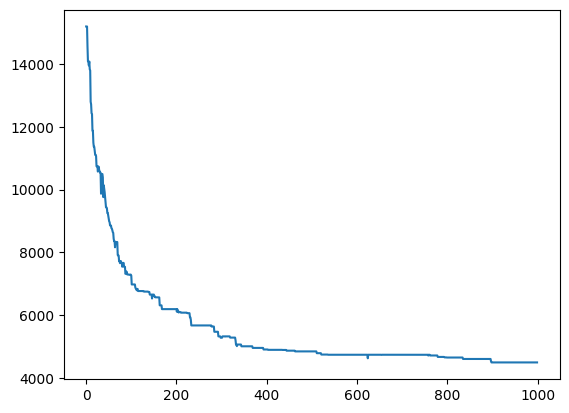

In [148]:
num_generations = 1000  # Here we define the number of generations 
best_distances = []

for generation in range(num_generations):
    # step 1: calculate fitness
    fitness_scores = [calculate_path_distance(path) for path in population]
    
    # step 2: Selection
    parents = select_parents(population, fitness_scores, 20)
    
    # step 3: Generate new population
    population = generate_new_population(parents)
    
    # step 4: Calculate the best path in the current generation
    best_distance = min(fitness_scores)

    best_distances.append(best_distance)


import matplotlib.pyplot as plt
plt.plot(best_distances)
print(min(best_distances))